# Model for DNA ejection from bacteriophage $\lambda$

In [3]:
# makes plots display inline in notebook interface:
%matplotlib inline 
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

# seaborn for data visualization (not installed by default in Anaconda)
# (filter suppresses a particular Warning issued by matplotlib)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import seaborn as sns

# pandas for handling data
import pandas as pd

# use emcee for MCMC sampling (not installed by default in Anaconda)
import emcee

## The experiment and some sample data

We measure the scattered intensity as a function of time as a virus ejects its DNA.  The intensity decreases when the ejection starts.  Here is a plot of one of our data sets (this data is available in the github repository). The intensity is normalized such that the average intensity before the ejection starts is 1.0 and the average value at the end of the ejection is 0.0.

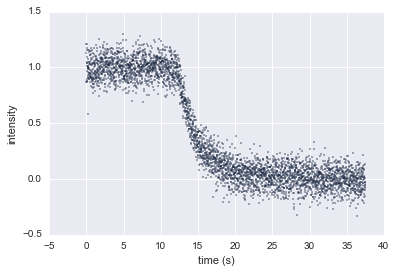

In [38]:
sample_ejection = pd.read_table('./tests/test_data/result_151119chamber3_5_X7_294,347.txt')
sample_ejection.columns = ['time', 'intensity']
ax = sample_ejection.plot(x='time', y='intensity', kind='scatter', s=1)
ax.set_xlabel('time (s)')

## What we want to infer

We want to infer the friction coefficient of the ejection as a function of the fraction of DNA in the virus.  We also want to know if the ejection "pauses" at any point or reverses itself; in other words, does the velocity decrease smoothly with time or not?  Evidence of "pauses" could be used to support the hypothesis that the DNA undergoes phase transitions during ejection.

## Model for friction coefficient

### Intensity as a function of fraction

Let $\phi(t)$, where $t$ is time, be the fraction of DNA in the virus. $\phi = 1$ before ejection, when the capsid is full, and $\phi=0$ after all the DNA has been ejected.  We assume that the measured intensity $I$ scales linearly with $\phi$.  We have some data to justify this assumption, but it's also the simplest assumption we can make:
$$I(t) = a\phi(t) + b + N(0, \sigma)$$
where a and b are constants, and $N$ is a normal distribution with mean of 0 and standard deviation of $\sigma$, which is meant to model the shot noise in our detector.  Shot noise is usually described by a Poisson distribution, but in our experiments the number of detection events is large enough that it is safe to approximate the Poisson as a Gaussian.

### Fraction as a function of friction

We can write down an equation of motion for the DNA using Newton's second law:
$$m\frac{d^2x}{dt^2} = F - F_D$$
where $F$ is the ejection force and $F_D$ is the drag force. Because we are at low Reynolds number, we can ignore the acceleration term, leaving us with
$$F = F_D$$

The drag force can be written as the product of a velocity $v$ times a friction coefficient $\gamma$:
$$F_D = \gamma v$$
We define the velocity in terms of the fraction $\phi$:
$$v = \frac{d\phi}{dt}$$.

Now, we assume that both the ejection force and the drag coefficient are _state functions_ -- that is, they depend only on the fraction of DNA and the buffer conditions: $F = F(\phi)$ and $\gamma = \gamma(\phi)$.  Any dependence on time is implicit. This is the assumption made in ref. [1].  Then we have:
$$\frac{d\phi}{dt} = \frac{F(\phi)}{\gamma(\phi)}$$. 

Ref. [1] also introduces a model for the ejection force $F(\phi)$, which we can also use here.  So $F(\phi)$ is known. The goal then is to infer $\gamma(\phi)$ from the intensity data.  First we need to write $\phi$ in terms of $\gamma$.  To do this, we need to integrate:
$$ \int_1^\phi \frac{F(\phi')}{\gamma(\phi')} d\phi'= \int_{t_0}^{t} dt' = t-t_0 $$
where $\phi'$ and $t'$ are dummy variables.  Solution for $\phi$ is implicit, but if we know $F(\phi)$ and $\gamma(\phi)$ (for example, we have an MCMC sample of $\gamma(\phi)$), we can construct $\phi(t)$ through numerical integration.


### Final statistical model

The generative model for the data is therefore the combination of the equations from the last two subsections.  We solve for $\phi(t)$ numerically as described at the end of "Fraction as a function of friction", then insert into the equation for $I(t)$ in the equation at the end of "Intensity as a function of fraction". 


[1]: Grayson, P.; Han, L.; Winther, T.; Phillips, R. Real-Time Observations of Single Bacteriophage λ DNA Ejections in Vitro. PNAS 2007, 104 (37), 14652–14657.
  
